## AWS MLOPs - Automate Machine Learning Workflows

In this tutorial, learn how to create and automate end-to-end machine learning (ML) workflows using Amazon SageMaker Pipelines, Amazon SageMaker Model Registry, and Amazon SageMaker Clarify.

SageMaker Pipelines is the first purpose-built continuous integration and continuous delivery (CI/CD) service for ML. With SageMaker Pipelines, you can automate different steps of the ML workflow, including data loading, data transformation, training, tuning, evaluation, and deployment. SageMaker Model Registry allows you to track model versions, their metadata such as use case grouping, and model performance metrics baselines in a central repository where it is easy to choose the right model for deployment based on your business requirements. SageMaker Clarify provides greater visibility into your training data and models so you can identify and limit bias and explain predictions.

In this tutorial, you will implement a SageMaker pipeline to build, train, and deploy an XGBoost binary classification model that predicts the likelihood of an auto insurance claim being fraudulent. You will use a synthetically generated auto insurance claims dataset. The raw inputs are two tables of insurance data: a claims table and a customers table. The claims table has a column named fraud indicating whether a claim was fraudulent or otherwise. Your pipeline will process the raw data; create training, validation, and test datasets; and build and evaluate a binary classification model. It will then use SageMaker Clarify to test model bias and explainability, and lastly deploy the model for inference.

## Implementation

### Step 1: Set up your Amazon SageMaker Studio domain

### Step 2: Set up a SageMaker Studio notebook and parameterize the pipeline

1. Import all required libraries

In [ ]:
import pandas as pd
import json
import boto3
import pathlib
import io
import sagemaker


from sagemaker.deserializers import CSVDeserializer
from sagemaker.serializers import CSVSerializer

from sagemaker.xgboost.estimator import XGBoost
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import (
    ProcessingInput, 
    ProcessingOutput, 
    ScriptProcessor
)
from sagemaker.inputs import TrainingInput

from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.steps import (
    ProcessingStep, 
    TrainingStep, 
    CreateModelStep
)
from sagemaker.workflow.check_job_config import CheckJobConfig
from sagemaker.workflow.parameters import (
    ParameterInteger, 
    ParameterFloat, 
    ParameterString, 
    ParameterBoolean
)
from sagemaker.workflow.clarify_check_step import (
    ModelBiasCheckConfig, 
    ClarifyCheckStep, 
    ModelExplainabilityCheckConfig
)
from sagemaker.workflow.step_collections import RegisterModel
from sagemaker.workflow.conditions import ConditionGreaterThanOrEqualTo
from sagemaker.workflow.properties import PropertyFile
from sagemaker.workflow.condition_step import ConditionStep
from sagemaker.workflow.functions import JsonGet

from sagemaker.workflow.lambda_step import (
    LambdaStep,
    LambdaOutput,
    LambdaOutputTypeEnum,
)
from sagemaker.lambda_helper import Lambda

from sagemaker.model_metrics import (
    MetricsSource, 
    ModelMetrics, 
    FileSource
)
from sagemaker.drift_check_baselines import DriftCheckBaselines

from sagemaker.image_uris import retrieve

2. set up SageMaker and S3 client objects using the SageMaker and AWS SDKs. 

These objects are needed to enable SageMaker to perform various actions such as deploying and invoking endpoints, and to interact with Amazon S3 and AWS Lambda. The code also sets up the S3 bucket locations where the raw and processed datasets and model artifacts are stored. Notice that the read and write buckets are separate. The read bucket is the public S3 bucket named sagemaker-sample-files and it contains the raw datasets. The write bucket is the default S3 bucket associated with your account named sagemaker-<your- Region>-<your-account-id> and it will be used later in this tutorial to store the processed datasets and artifacts.

In [ ]:
# Instantiate AWS services session and client objects
sess = sagemaker.Session()
write_bucket = sess.default_bucket()
write_prefix = "fraud-detect-demo"

region = sess.boto_region_name
s3_client = boto3.client("s3", region_name=region)
sm_client = boto3.client("sagemaker", region_name=region)
sm_runtime_client = boto3.client("sagemaker-runtime")

# Fetch SageMaker execution role
sagemaker_role = sagemaker.get_execution_role()


# S3 locations used for parameterizing the notebook run
read_bucket = "sagemaker-sample-files"
read_prefix = "datasets/tabular/synthetic_automobile_claims" 

# S3 location where raw data to be fetched from
raw_data_key = f"s3://{read_bucket}/{read_prefix}"

# S3 location where processed data to be uploaded
processed_data_key = f"{write_prefix}/processed"

# S3 location where train data to be uploaded
train_data_key = f"{write_prefix}/train"

# S3 location where validation data to be uploaded
validation_data_key = f"{write_prefix}/validation"

# S3 location where test data to be uploaded
test_data_key = f"{write_prefix}/test"


# Full S3 paths
claims_data_uri = f"{raw_data_key}/claims.csv"
customers_data_uri = f"{raw_data_key}/customers.csv"
output_data_uri = f"s3://{write_bucket}/{write_prefix}/"
scripts_uri = f"s3://{write_bucket}/{write_prefix}/scripts"
estimator_output_uri = f"s3://{write_bucket}/{write_prefix}/training_jobs"
processing_output_uri = f"s3://{write_bucket}/{write_prefix}/processing_jobs"
model_eval_output_uri = f"s3://{write_bucket}/{write_prefix}/model_eval"
clarify_bias_config_output_uri = f"s3://{write_bucket}/{write_prefix}/model_monitor/bias_config"
clarify_explainability_config_output_uri = f"s3://{write_bucket}/{write_prefix}/model_monitor/explainability_config"
bias_report_output_uri = f"s3://{write_bucket}/{write_prefix}/clarify_output/pipeline/bias"
explainability_report_output_uri = f"s3://{write_bucket}/{write_prefix}/clarify_output/pipeline/explainability"

# Retrieve training image
training_image = retrieve(framework="xgboost", region=region, version="1.3-1")

3.  set the names for the various SageMaker pipeline components, such as the model and the endpoint, and specify training and inference instance types and counts. These values will be used to parameterize your pipeline.

In [ ]:
# Set names of pipeline objects
pipeline_name = "FraudDetectXGBPipeline"
pipeline_model_name = "fraud-detect-xgb-pipeline"
model_package_group_name = "fraud-detect-xgb-model-group"
base_job_name_prefix = "fraud-detect"
endpoint_config_name = f"{pipeline_model_name}-endpoint-config"
endpoint_name = f"{pipeline_model_name}-endpoint"

# Set data parameters
target_col = "fraud"

# Set instance types and counts
process_instance_type = "ml.c5.xlarge"
train_instance_count = 1
train_instance_type = "ml.m4.xlarge"
predictor_instance_count = 1
predictor_instance_type = "ml.m4.xlarge"
clarify_instance_count = 1
clarify_instance_type = "ml.m4.xlarge"

4. SageMaker Pipelines supports parameterization, which allows you to specify input parameters at runtime without changing your pipeline code. You can use the modules available under the sagemaker.workflow.parameters module, such as ParameterInteger, ParameterFloat, ParameterString, and ParameterBoolean, to specify pipeline parameters of various data types. Copy, paste, and run the following code to set up multiple input parameters, including SageMaker Clarify configurations.

In [ ]:
# Set up pipeline input parameters

# Set processing instance type
process_instance_type_param = ParameterString(
    name="ProcessingInstanceType",
    default_value=process_instance_type,
)

# Set training instance type
train_instance_type_param = ParameterString(
    name="TrainingInstanceType",
    default_value=train_instance_type,
)

# Set training instance count
train_instance_count_param = ParameterInteger(
    name="TrainingInstanceCount",
    default_value=train_instance_count
)

# Set deployment instance type
deploy_instance_type_param = ParameterString(
    name="DeployInstanceType",
    default_value=predictor_instance_type,
)

# Set deployment instance count
deploy_instance_count_param = ParameterInteger(
    name="DeployInstanceCount",
    default_value=predictor_instance_count
)

# Set Clarify check instance type
clarify_instance_type_param = ParameterString(
    name="ClarifyInstanceType",
    default_value=clarify_instance_type,
)

# Set model bias check params
skip_check_model_bias_param = ParameterBoolean(
    name="SkipModelBiasCheck", 
    default_value=False
)

register_new_baseline_model_bias_param = ParameterBoolean(
    name="RegisterNewModelBiasBaseline",
    default_value=False
)

supplied_baseline_constraints_model_bias_param = ParameterString(
    name="ModelBiasSuppliedBaselineConstraints", 
    default_value=""
)

# Set model explainability check params
skip_check_model_explainability_param = ParameterBoolean(
    name="SkipModelExplainabilityCheck", 
    default_value=False
)

register_new_baseline_model_explainability_param = ParameterBoolean(
    name="RegisterNewModelExplainabilityBaseline",
    default_value=False
)

supplied_baseline_constraints_model_explainability_param = ParameterString(
    name="ModelExplainabilitySuppliedBaselineConstraints", 
    default_value=""
)

# Set model approval param
model_approval_status_param = ParameterString(
    name="ModelApprovalStatus", default_value="Approved"
)

### Step 3: Build the pipeline components

A pipeline is a sequence of steps that can be individually built and then put together to form an ML workflow. The following diagram shows the high-level steps of a pipeline.

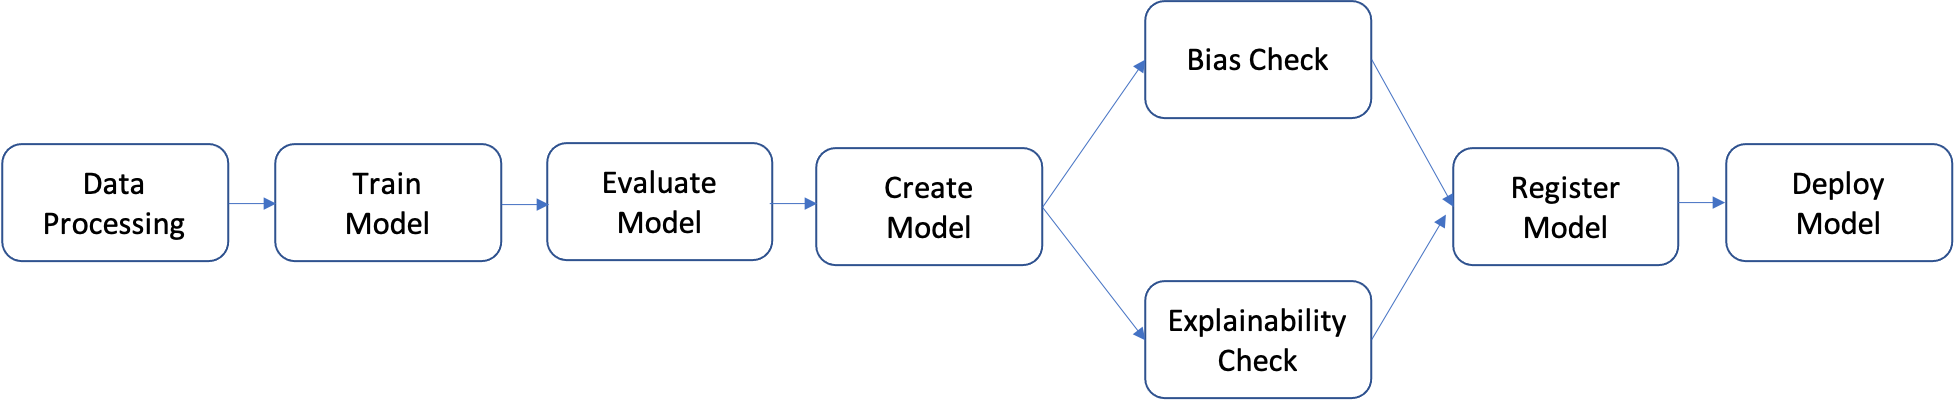

In this tutorial, you build a pipeline with the following steps:

1. Data processing step: Runs a SageMaker Processing job using the input raw data in S3 and outputs training, validation, and test splits to S3.
2. Training step: Trains an XGBoost model using SageMaker training jobs with training and validation data in S3 as inputs, and stores the trained model artifact in S3.
3. Evaluation step: Evaluates the model on the test dataset by running a SageMaker Processing job using the test data and the model artifact in S3 as inputs, and stores the output model performance evaluation report in S3.
4. Conditional step: Compares model performance on the test dataset against the threshold. Runs a SageMaker Pipelines predefined step using the model performance evaluation report in S3 as input, and stores the output list of pipeline steps that will be executed if model performance is acceptable.
5. Create model step: Runs a SageMaker Pipelines predefined step using the model artifact in S3 as an input, and stores the output SageMaker model in S3.
6. Bias check step: Checks for model bias using SageMaker Clarify with the training data and model artifact in S3 as inputs and stores the model bias report and baseline metrics in S3.
7. Model explainability step: Runs SageMaker Clarify with the training data and model artifact in S3 as inputs, and stores the model explainability report and baseline metrics in S3.
8. Register step: Runs a SageMaker Pipelines predefined step using the model, bias, and explainability baseline metrics as inputs to register the model in the SageMaker Model Registry.
9. Deploy step: Runs a SageMaker Pipelines predefined step using an AWS Lambda handler function, the model, and the endpoint configuration as inputs to deploy the model to a SageMaker Real-Time Inference endpoint.

SageMaker Pipelines provides many predefined step types, such as steps for data processing, model training, model tuning, and batch transformation. For more information, see Pipeline Steps in the Amazon SageMaker Developer Guide. In the following steps, you configure and define each pipeline step individually, and then define the pipeline itself by combining the pipeline steps with the input parameters.

Data processing step: In this step you prepare a Python script to ingest raw files; perform processing such as missing values imputation and feature engineering; and curate the training, validation, and test splits to be used for model building. 

In [ ]:
%%writefile preprocessing.py
import argparse
import pathlib
import boto3
import os
import pandas as pd
import logging
from sklearn.model_selection import train_test_split

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--train-ratio", type=float, default=0.8)
    parser.add_argument("--validation-ratio", type=float, default=0.1)
    parser.add_argument("--test-ratio", type=float, default=0.1)
    args, _ = parser.parse_known_args()
    logger.info("Received arguments {}".format(args))
    
    # Set local path prefix in the processing container
    local_dir = "/opt/ml/processing"    
    
    input_data_path_claims = os.path.join("/opt/ml/processing/claims", "claims.csv")
    input_data_path_customers = os.path.join("/opt/ml/processing/customers", "customers.csv")
    
    logger.info("Reading claims data from {}".format(input_data_path_claims))
    df_claims = pd.read_csv(input_data_path_claims)
    
    logger.info("Reading customers data from {}".format(input_data_path_customers))
    df_customers = pd.read_csv(input_data_path_customers)
    
    logger.debug("Formatting column names.")
    # Format column names
    df_claims = df_claims.rename({c : c.lower().strip().replace(' ', '_') for c in df_claims.columns}, axis = 1)
    df_customers = df_customers.rename({c : c.lower().strip().replace(' ', '_') for c in df_customers.columns}, axis = 1)
    
    logger.debug("Joining datasets.")
    # Join datasets
    df_data = df_claims.merge(df_customers, on = 'policy_id', how = 'left')

    # Drop selected columns not required for model building
    df_data = df_data.drop(['customer_zip'], axis = 1)
    
    # Select Ordinal columns
    ordinal_cols = ["police_report_available", "policy_liability", "customer_education"]

    # Select categorical columns and filling with na
    cat_cols_all = list(df_data.select_dtypes('object').columns)
    cat_cols = [c for c in cat_cols_all if c not in ordinal_cols]
    df_data[cat_cols] = df_data[cat_cols].fillna('na')
    
    logger.debug("One-hot encoding categorical columns.")
    # One-hot encoding categorical columns
    df_data = pd.get_dummies(df_data, columns = cat_cols)
    
    logger.debug("Encoding ordinal columns.")
    # Ordinal encoding
    mapping = {
               "Yes": "1",
               "No": "0" 
              }
    df_data['police_report_available'] = df_data['police_report_available'].map(mapping)
    df_data['police_report_available'] = df_data['police_report_available'].astype(float)

    mapping = {
               "15/30": "0",
               "25/50": "1", 
               "30/60": "2",
               "100/200": "3"
              }
    
    df_data['policy_liability'] = df_data['policy_liability'].map(mapping)
    df_data['policy_liability'] = df_data['policy_liability'].astype(float)

    mapping = {
               "Below High School": "0",
               "High School": "1", 
               "Associate": "2",
               "Bachelor": "3",
               "Advanced Degree": "4"
              }
    
    df_data['customer_education'] = df_data['customer_education'].map(mapping)
    df_data['customer_education'] = df_data['customer_education'].astype(float)
    
    df_processed = df_data.copy()
    df_processed.columns = [c.lower() for c in df_data.columns]
    df_processed = df_processed.drop(["policy_id", "customer_gender_unkown"], axis=1)
    
    # Split into train, validation, and test sets
    train_ratio = args.train_ratio
    val_ratio = args.validation_ratio
    test_ratio = args.test_ratio
    
    logger.debug("Splitting data into train, validation, and test sets")
    
    y = df_processed['fraud']
    X = df_processed.drop(['fraud'], axis = 1)
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_ratio, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_ratio, random_state=42)

    train_df = pd.concat([y_train, X_train], axis = 1)
    val_df = pd.concat([y_val, X_val], axis = 1)
    test_df = pd.concat([y_test, X_test], axis = 1)
    dataset_df = pd.concat([y, X], axis = 1)
    
    logger.info("Train data shape after preprocessing: {}".format(train_df.shape))
    logger.info("Validation data shape after preprocessing: {}".format(val_df.shape))
    logger.info("Test data shape after preprocessing: {}".format(test_df.shape))
    
    # Save processed datasets to the local paths in the processing container.
    # SageMaker will upload the contents of these paths to S3 bucket
    logger.debug("Writing processed datasets to container local path.")
    train_output_path = os.path.join(f"{local_dir}/train", "train.csv")
    validation_output_path = os.path.join(f"{local_dir}/val", "validation.csv")
    test_output_path = os.path.join(f"{local_dir}/test", "test.csv")
    full_processed_output_path = os.path.join(f"{local_dir}/full", "dataset.csv")

    logger.info("Saving train data to {}".format(train_output_path))
    train_df.to_csv(train_output_path, index=False)
    
    logger.info("Saving validation data to {}".format(validation_output_path))
    val_df.to_csv(validation_output_path, index=False)

    logger.info("Saving test data to {}".format(test_output_path))
    test_df.to_csv(test_output_path, index=False)
    
    logger.info("Saving full processed data to {}".format(full_processed_output_path))
    dataset_df.to_csv(full_processed_output_path, index=False)


instantiate the processor and the SageMaker Pipelines step to run the processing script. Since the processing script is written in Pandas, you use a SKLearnProcessor. The SageMaker Pipelines ProcessingStep function takes the following arguments: the processor, the input S3 locations for raw datasets, and the output S3 locations to save processed datasets. Additional arguments such as training, validation, and test split ratios are provided through the job_arguments argument.

In [ ]:
from sagemaker.workflow.pipeline_context import PipelineSession
# Upload processing script to S3
s3_client.upload_file(
    Filename="preprocessing.py", Bucket=write_bucket, Key=f"{write_prefix}/scripts/preprocessing.py"
)

# Define the SKLearnProcessor configuration
sklearn_processor = SKLearnProcessor(
    framework_version="0.23-1",
    role=sagemaker_role,
    instance_count=1,
    instance_type=process_instance_type,
    base_job_name=f"{base_job_name_prefix}-processing",
)

# Define pipeline processing step
process_step = ProcessingStep(
    name="DataProcessing",
    processor=sklearn_processor,
    inputs=[
        ProcessingInput(source=claims_data_uri, destination="/opt/ml/processing/claims"),
        ProcessingInput(source=customers_data_uri, destination="/opt/ml/processing/customers")
    ],
    outputs=[
        ProcessingOutput(destination=f"{processing_output_uri}/train_data", output_name="train_data", source="/opt/ml/processing/train"),
        ProcessingOutput(destination=f"{processing_output_uri}/validation_data", output_name="validation_data", source="/opt/ml/processing/val"),
        ProcessingOutput(destination=f"{processing_output_uri}/test_data", output_name="test_data", source="/opt/ml/processing/test"),
        ProcessingOutput(destination=f"{processing_output_uri}/processed_data", output_name="processed_data", source="/opt/ml/processing/full")
    ],
    job_arguments=[
        "--train-ratio", "0.8", 
        "--validation-ratio", "0.1",
        "--test-ratio", "0.1"
    ],
    code=f"s3://{write_bucket}/{write_prefix}/scripts/preprocessing.py"
)

run the following code block to prepare the training script. This script encapsulates the training logic for the XGBoost binary classifier. Hyperparameters used in model training are provided later in the tutorial through the training step definition.

In [ ]:
%%writefile xgboost_train.py

import argparse
import os
import joblib
import json
import pandas as pd
import xgboost as xgb
from sklearn.metrics import roc_auc_score

if __name__ == "__main__":
    parser = argparse.ArgumentParser()

    # Hyperparameters and algorithm parameters are described here
    parser.add_argument("--num_round", type=int, default=100)
    parser.add_argument("--max_depth", type=int, default=3)
    parser.add_argument("--eta", type=float, default=0.2)
    parser.add_argument("--subsample", type=float, default=0.9)
    parser.add_argument("--colsample_bytree", type=float, default=0.8)
    parser.add_argument("--objective", type=str, default="binary:logistic")
    parser.add_argument("--eval_metric", type=str, default="auc")
    parser.add_argument("--nfold", type=int, default=3)
    parser.add_argument("--early_stopping_rounds", type=int, default=3)
    

    # SageMaker specific arguments. Defaults are set in the environment variables
    # Set location of input training data
    parser.add_argument("--train_data_dir", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    # Set location of input validation data
    parser.add_argument("--validation_data_dir", type=str, default=os.environ.get("SM_CHANNEL_VALIDATION"))
    # Set location where trained model will be stored. Default set by SageMaker, /opt/ml/model
    parser.add_argument("--model_dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    # Set location where model artifacts will be stored. Default set by SageMaker, /opt/ml/output/data
    parser.add_argument("--output_data_dir", type=str, default=os.environ.get("SM_OUTPUT_DATA_DIR"))
    
    args = parser.parse_args()

    data_train = pd.read_csv(f"{args.train_data_dir}/train.csv")
    train = data_train.drop("fraud", axis=1)
    label_train = pd.DataFrame(data_train["fraud"])
    dtrain = xgb.DMatrix(train, label=label_train)
    
    
    data_validation = pd.read_csv(f"{args.validation_data_dir}/validation.csv")
    validation = data_validation.drop("fraud", axis=1)
    label_validation = pd.DataFrame(data_validation["fraud"])
    dvalidation = xgb.DMatrix(validation, label=label_validation)
    
    # Choose XGBoost model hyperparameters
    params = {"max_depth": args.max_depth,
              "eta": args.eta,
              "objective": args.objective,
              "subsample" : args.subsample,
              "colsample_bytree":args.colsample_bytree
             }
    
    num_boost_round = args.num_round
    nfold = args.nfold
    early_stopping_rounds = args.early_stopping_rounds
    
    # Cross-validate train XGBoost model
    cv_results = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=num_boost_round,
        nfold=nfold,
        early_stopping_rounds=early_stopping_rounds,
        metrics=["auc"],
        seed=42,
    )
    
    model = xgb.train(params=params, dtrain=dtrain, num_boost_round=len(cv_results))
    
    train_pred = model.predict(dtrain)
    validation_pred = model.predict(dvalidation)
    
    train_auc = roc_auc_score(label_train, train_pred)
    validation_auc = roc_auc_score(label_validation, validation_pred)
    
    print(f"[0]#011train-auc:{train_auc:.2f}")
    print(f"[0]#011validation-auc:{validation_auc:.2f}")

    metrics_data = {"hyperparameters" : params,
                    "binary_classification_metrics": {"validation:auc": {"value": validation_auc},
                                                      "train:auc": {"value": train_auc}
                                                     }
                   }
              
    # Save the evaluation metrics to the location specified by output_data_dir
    metrics_location = args.output_data_dir + "/metrics.json"
    
    # Save the trained model to the location specified by model_dir
    model_location = args.model_dir + "/xgboost-model"

    with open(metrics_location, "w") as f:
        json.dump(metrics_data, f)

    with open(model_location, "wb") as f:
        joblib.dump(model, f)

Set up model training using a SageMaker XGBoost estimator and the SageMaker Pipelines TrainingStep function.

In [ ]:
# Set XGBoost model hyperparameters 
hyperparams = {  
"eval_metric" : "auc",
"objective": "binary:logistic",
"num_round": "5",
"max_depth":"5",
"subsample":"0.75",
"colsample_bytree":"0.75",
"eta":"0.5"
}

# Set XGBoost estimator
xgb_estimator = XGBoost(
entry_point="xgboost_train.py", 
output_path=estimator_output_uri,
code_location=estimator_output_uri,
hyperparameters=hyperparams,
role=sagemaker_role,
# Fetch instance type and count from pipeline parameters
instance_count=train_instance_count,
instance_type=train_instance_type,
framework_version="1.3-1"
)

# Access the location where the preceding processing step saved train and validation datasets
# Pipeline step properties can give access to outputs which can be used in succeeding steps
s3_input_train = TrainingInput(
s3_data=process_step.properties.ProcessingOutputConfig.Outputs["train_data"].S3Output.S3Uri, 
content_type="csv", 
s3_data_type="S3Prefix"
)
s3_input_validation = TrainingInput(
s3_data=process_step.properties.ProcessingOutputConfig.Outputs["validation_data"].S3Output.S3Uri,
content_type="csv",
s3_data_type="S3Prefix"
)

# Set pipeline training step
train_step = TrainingStep(
name="XGBModelTraining",
estimator=xgb_estimator,
inputs={
"train":s3_input_train, # Train channel 
"validation": s3_input_validation # Validation channel
}
)

run the following code block, which will be used to create a SageMaker model using the SageMaker Pipelines CreateModelStep function. This step utilizes the output of the training step to package the model for deployment. 

In [ ]:
# Create a SageMaker model
model = sagemaker.model.Model(
    image_uri=training_image,
    model_data=train_step.properties.ModelArtifacts.S3ModelArtifacts,
    sagemaker_session=sess,
    role=sagemaker_role
)

# Specify model deployment instance type
inputs = sagemaker.inputs.CreateModelInput(instance_type=deploy_instance_type_param)

create_model_step = CreateModelStep(name="FraudDetModel", model=model, inputs=inputs)

In an ML workflow, it is important to assess a trained model for potential biases and understand how the various features in the input data affect model prediction. SageMaker Pipelines provides a ClarifyCheckStep function that can be used to perform three types of checks: data bias check (pre-training), model bias check (post-training), and model explainability check. To reduce the running time, in this tutorial, you implement only bias and explainability checks. Copy, paste, and run the following code block to set up SageMaker Clarify for model bias check.

In [ ]:
# Set up common configuration parameters to be used across multiple steps
check_job_config = CheckJobConfig(
    role=sagemaker_role,
    instance_count=1,
    instance_type=clarify_instance_type,
    volume_size_in_gb=30,
    sagemaker_session=sess,
)

# Set up configuration of data to be used for model bias check
model_bias_data_config = sagemaker.clarify.DataConfig(
    # Fetch S3 location where processing step saved train data
    s3_data_input_path=process_step.properties.ProcessingOutputConfig.Outputs["train_data"].S3Output.S3Uri,
    s3_output_path=bias_report_output_uri,
    label=target_col,
    dataset_type="text/csv",
    s3_analysis_config_output_path=clarify_bias_config_output_uri
)

# Set up details of the trained model to be checked for bias
model_config = sagemaker.clarify.ModelConfig(
    # Pull model name from model creation step
    model_name=create_model_step.properties.ModelName,
    instance_count=train_instance_count,
    instance_type=train_instance_type
)

# Set up column and categories that are to be checked for bias
model_bias_config = sagemaker.clarify.BiasConfig(
    label_values_or_threshold=[0],
    facet_name="customer_gender_female",
    facet_values_or_threshold=[1]
)

# Set up model predictions configuration to get binary labels from probabilities
model_predictions_config = sagemaker.clarify.ModelPredictedLabelConfig(probability_threshold=0.5)

model_bias_check_config = ModelBiasCheckConfig(
    data_config=model_bias_data_config,
    data_bias_config=model_bias_config,
    model_config=model_config,
    model_predicted_label_config=model_predictions_config,
    methods=["DPPL"]
)

# Set up pipeline model bias check step
model_bias_check_step = ClarifyCheckStep(
    name="ModelBiasCheck",
    clarify_check_config=model_bias_check_config,
    check_job_config=check_job_config,
    skip_check=skip_check_model_bias_param,
    register_new_baseline=register_new_baseline_model_bias_param,
    supplied_baseline_constraints=supplied_baseline_constraints_model_bias_param
)

run the following code block to set up model explainability checks. This step provides insights such as feature importance (how input features impact model predictions).

In [ ]:
# Set configuration of data to be used for model explainability check
model_explainability_data_config = sagemaker.clarify.DataConfig(
    # Fetch S3 location where processing step saved train data
    s3_data_input_path=process_step.properties.ProcessingOutputConfig.Outputs["train_data"].S3Output.S3Uri,
    s3_output_path=explainability_report_output_uri,
    label=target_col,
    dataset_type="text/csv",
    s3_analysis_config_output_path=clarify_explainability_config_output_uri 
)

# Set SHAP configuration for Clarify to compute global and local SHAP values for feature importance
shap_config = sagemaker.clarify.SHAPConfig(
    seed=42, 
    num_samples=100,
    agg_method="mean_abs",
    save_local_shap_values=True
)

model_explainability_config = ModelExplainabilityCheckConfig(
    data_config=model_explainability_data_config,
    model_config=model_config,
    explainability_config=shap_config
)

# Set pipeline model explainability check step
model_explainability_step = ClarifyCheckStep(
    name="ModelExplainabilityCheck",
    clarify_check_config=model_explainability_config,
    check_job_config=check_job_config,
    skip_check=skip_check_model_explainability_param,
    register_new_baseline=register_new_baseline_model_explainability_param,
    supplied_baseline_constraints=supplied_baseline_constraints_model_explainability_param
)

In production systems, not all trained models are deployed. Usually, only models that perform better than the threshold for a chosen evaluation metric are deployed. In this step, you will build a Python script that scores the model on a test set using the Receiver Operating Characteristic Area Under the Curve (ROC-AUC) metric. The performance of the model against this metric is used in a subsequent step to determine if the model should be registered and deployed. Copy, paste, and run the following code to build an evaluation script that ingests a test dataset and generates the AUC metric.

In [ ]:
%%writefile evaluate.py

import json
import logging
import pathlib
import pickle
import tarfile

import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.metrics import roc_auc_score

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())


if __name__ == "__main__":
    model_path = "/opt/ml/processing/model/model.tar.gz"
    with tarfile.open(model_path) as tar:
        tar.extractall(path=".")

    logger.debug("Loading xgboost model.")
    # The name of the file should match how the model was saved in the training script
    model = pickle.load(open("xgboost-model", "rb"))

    logger.debug("Reading test data.")
    test_local_path = "/opt/ml/processing/test/test.csv"
    df_test = pd.read_csv(test_local_path)
    
    # Extract test set target column
    y_test = df_test.iloc[:, 0].values
   
    cols_when_train = model.feature_names
    # Extract test set feature columns
    X = df_test[cols_when_train].copy()
    X_test = xgb.DMatrix(X)

    logger.info("Generating predictions for test data.")
    pred = model.predict(X_test)
    
    # Calculate model evaluation score
    logger.debug("Calculating ROC-AUC score.")
    auc = roc_auc_score(y_test, pred)
    metric_dict = {
        "classification_metrics": {"roc_auc": {"value": auc}}
    }
    
    # Save model evaluation metrics
    output_dir = "/opt/ml/processing/evaluation"
    pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)

    logger.info("Writing evaluation report with ROC-AUC: %f", auc)
    evaluation_path = f"{output_dir}/evaluation.json"
    with open(evaluation_path, "w") as f:
        f.write(json.dumps(metric_dict))

Next, copy, paste, and run the following code block to instantiate the processor and the SageMaker Pipelines step to run the evaluation script. 

In [ ]:
# Upload model evaluation script to S3
s3_client.upload_file(
    Filename="evaluate.py", Bucket=write_bucket, Key=f"{write_prefix}/scripts/evaluate.py"
)

eval_processor = ScriptProcessor(
    image_uri=training_image,
    command=["python3"],
    instance_type=predictor_instance_type,
    instance_count=predictor_instance_count,
    base_job_name=f"{base_job_name_prefix}-model-eval",
    sagemaker_session=sess,
    role=sagemaker_role,
)
evaluation_report = PropertyFile(
    name="FraudDetEvaluationReport",
    output_name="evaluation",
    path="evaluation.json",
)

# Set model evaluation step
evaluation_step = ProcessingStep(
    name="XGBModelEvaluate",
    processor=eval_processor,
    inputs=[
        ProcessingInput(
            # Fetch S3 location where train step saved model artifacts
            source=train_step.properties.ModelArtifacts.S3ModelArtifacts,
            destination="/opt/ml/processing/model",
        ),
        ProcessingInput(
            # Fetch S3 location where processing step saved test data
            source=process_step.properties.ProcessingOutputConfig.Outputs["test_data"].S3Output.S3Uri,
            destination="/opt/ml/processing/test",
        ),
    ],
    outputs=[
        ProcessingOutput(destination=f"{model_eval_output_uri}", output_name="evaluation", source="/opt/ml/processing/evaluation"),
    ],
    code=f"s3://{write_bucket}/{write_prefix}/scripts/evaluate.py",
    property_files=[evaluation_report],
)

With SageMaker Model Registry, you can catalog models, manage model versions, and selectively deploy models to production. Copy, paste, and run the following code block to set up the model registry step. The two parameters, model_metrics and drift_check_baselines, contain baseline metrics calculated previously in the tutorial by the ClarifyCheckStep function. You can also provide your own custom baseline metrics. The intention behind these parameters is to provide a way to configure the baselines associated with a model so they can be used in drift checks and model-monitoring jobs. Each time a pipeline is executed, you can choose to update these parameters with newly calculated baselines.

In [ ]:
# Fetch baseline constraints to record in model registry
model_metrics = ModelMetrics(
    bias_post_training=MetricsSource(
        s3_uri=model_bias_check_step.properties.CalculatedBaselineConstraints,
        content_type="application/json"
    ),
    explainability=MetricsSource(
        s3_uri=model_explainability_step.properties.CalculatedBaselineConstraints,
        content_type="application/json"
    ),
)

# Fetch baselines to record in model registry for drift check
drift_check_baselines = DriftCheckBaselines(
    bias_post_training_constraints=MetricsSource(
        s3_uri=model_bias_check_step.properties.BaselineUsedForDriftCheckConstraints,
        content_type="application/json",
    ),
    explainability_constraints=MetricsSource(
        s3_uri=model_explainability_step.properties.BaselineUsedForDriftCheckConstraints,
        content_type="application/json",
    ),
    explainability_config_file=FileSource(
        s3_uri=model_explainability_config.monitoring_analysis_config_uri,
        content_type="application/json",
    ),
)

# Define register model step
register_step = RegisterModel(
    name="XGBRegisterModel",
    estimator=xgb_estimator,
    # Fetching S3 location where train step saved model artifacts
    model_data=train_step.properties.ModelArtifacts.S3ModelArtifacts,
    content_types=["text/csv"],
    response_types=["text/csv"],
    inference_instances=[predictor_instance_type],
    transform_instances=[predictor_instance_type],
    model_package_group_name=model_package_group_name,
    approval_status=model_approval_status_param,
    # Registering baselines metrics that can be used for model monitoring
    model_metrics=model_metrics,
    drift_check_baselines=drift_check_baselines
)

With Amazon SageMaker, a registered model can be deployed for inference in several ways. In this step, you deploy the model using the LambdaStep function. Copy, paste, and run the following code to define the Lambda handler function. This is the custom Python script that takes in model attributes, such as model name, and deploys to a real-time endpoint.

In [ ]:
%%writefile lambda_deployer.py

"""
Lambda function creates an endpoint configuration and deploys a model to real-time endpoint. 
Required parameters for deployment are retrieved from the event object
"""

import json
import boto3


def lambda_handler(event, context):
    sm_client = boto3.client("sagemaker")

    # Details of the model created in the Pipeline CreateModelStep
    model_name = event["model_name"]
    model_package_arn = event["model_package_arn"]
    endpoint_config_name = event["endpoint_config_name"]
    endpoint_name = event["endpoint_name"]
    role = event["role"]
    instance_type = event["instance_type"]
    instance_count = event["instance_count"]
    primary_container = {"ModelPackageName": model_package_arn}

    # Create model
    model = sm_client.create_model(
        ModelName=model_name,
        PrimaryContainer=primary_container,
        ExecutionRoleArn=role
    )

    # Create endpoint configuration
    create_endpoint_config_response = sm_client.create_endpoint_config(
        EndpointConfigName=endpoint_config_name,
        ProductionVariants=[
        {
            "VariantName": "Alltraffic",
            "ModelName": model_name,
            "InitialInstanceCount": instance_count,
            "InstanceType": instance_type,
            "InitialVariantWeight": 1
        }
        ]
    )

    # Create endpoint
    create_endpoint_response = sm_client.create_endpoint(
        EndpointName=endpoint_name, 
        EndpointConfigName=endpoint_config_name
    )

Run the following code block to create the LambdaStep. All parameters such as model, endpoint name, and deployment instance type and count are provided using the inputs argument.

In [ ]:
# The function name must contain sagemaker
function_name = "sagemaker-fraud-det-demo-lambda-step"
# Define Lambda helper class can be used to create the Lambda function required in the Lambda step
func = Lambda(
    function_name=function_name,
    execution_role_arn=sagemaker_role,
    script="lambda_deployer.py",
    handler="lambda_deployer.lambda_handler",
    timeout=600,
    memory_size=3008,
)

# The inputs used in the lambda handler are passed through the inputs argument in the 
# LambdaStep and retrieved via the `event` object within the `lambda_handler` function

lambda_deploy_step = LambdaStep(
    name="LambdaStepRealTimeDeploy",
    lambda_func=func,
    inputs={
        "model_name": pipeline_model_name,
        "endpoint_config_name": endpoint_config_name,
        "endpoint_name": endpoint_name,
        "model_package_arn": register_step.steps[0].properties.ModelPackageArn,
        "role": sagemaker_role,
        "instance_type": deploy_instance_type_param,
        "instance_count": deploy_instance_count_param
    }
)

In this step, you use the ConditionStep to compare the current model’s performance based on the Area Under Curve (AUC) metric. Only if the performance is greater than or equal to a threshold AUC (here chosen to be 0.7), the pipeline will perform bias and explainability checks, register the model, and deploy it. Conditional steps like this one help in selective deployment of the best models to production. Copy, paste, and run the following code to define the conditional step.

In [ ]:
# Evaluate model performance on test set
cond_gte = ConditionGreaterThanOrEqualTo(
    left=JsonGet(
        step_name=evaluation_step.name,
        property_file=evaluation_report,
        json_path="classification_metrics.roc_auc.value",
    ),
    right=0.7, # Threshold to compare model performance against
)
condition_step = ConditionStep(
    name="CheckFraudDetXGBEvaluation",
    conditions=[cond_gte],
    if_steps=[create_model_step, model_bias_check_step, model_explainability_step, register_step, lambda_deploy_step], 
    else_steps=[]
)

### Step 4: Build and run the pipeline

After defining all of the component steps, you can assemble them into a SageMaker Pipelines object. There is no need for you to specify the order of execution since SageMaker Pipelines automatically infers the execution sequence based on the dependencies between the steps.

In [ ]:
# Create the Pipeline with all component steps and parameters
pipeline = Pipeline(
    name=pipeline_name,
    parameters=[process_instance_type_param, 
                train_instance_type_param, 
                train_instance_count_param, 
                deploy_instance_type_param,
                deploy_instance_count_param,
                clarify_instance_type_param,
                skip_check_model_bias_param,
                register_new_baseline_model_bias_param,
                supplied_baseline_constraints_model_bias_param,
                skip_check_model_explainability_param,
                register_new_baseline_model_explainability_param,
                supplied_baseline_constraints_model_explainability_param,
                model_approval_status_param],
    steps=[
        process_step,
        train_step,
        evaluation_step,
        condition_step
    ],
    sagemaker_session=sess
    
)

In [ ]:
# Create a new or update existing Pipeline
pipeline.upsert(role_arn=sagemaker_role)

# Full Pipeline description
pipeline_definition = json.loads(pipeline.describe()['PipelineDefinition'])
pipeline_definition

Execute the pipeline by running the following code statement. Pipeline execution parameters are provided as arguments in this step.

In [ ]:
# Execute Pipeline
start_response = pipeline.start(parameters=dict(
        SkipModelBiasCheck=True,
        RegisterNewModelBiasBaseline=True,
        SkipModelExplainabilityCheck=True,
        RegisterNewModelExplainabilityBaseline=True)
                               )

### Step 5: Test the pipeline by invoking the endpoint

After the Endpoint status changes to InService, copy, paste, and run the following code to invoke the endpoint and run sample inferences. The code returns the model predictions of the first five samples in the test dataset.

In [ ]:
# Fetch test data to run predictions with the endpoint
test_df = pd.read_csv(f"{processing_output_uri}/test_data/test.csv")

# Create SageMaker Predictor from the deployed endpoint
predictor = sagemaker.predictor.Predictor(endpoint_name, 
                                          sagemaker_session=sess,
                                          serializer=CSVSerializer(),
                                          deserializer=CSVDeserializer()
                                         )
# Test endpoint with payload of 5 samples
payload = test_df.drop(["fraud"], axis=1).iloc[:5]
result = predictor.predict(payload.values)
prediction_df = pd.DataFrame()
prediction_df["Prediction"] = result
prediction_df["Label"] = test_df["fraud"].iloc[:5].values
prediction_df

### Step 6: Clean up the resources

It is a best practice to delete resources that you are no longer using so that you don't incur unintended charges.


In [ ]:
# Delete the Lambda function
func.delete()

# Delete the endpoint
sm_client.delete_endpoint(EndpointName=endpoint_name)

# Delete the EndpointConfig
sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)

# Delete the model
sm_client.delete_model(ModelName=pipeline_model_name)

# Delete the pipeline
sm_client.delete_pipeline(PipelineName=pipeline_name)